In [3]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine

# SQLAlchemy connection string
user = "root"
password = "gigitod07"
host = "localhost"
port = 3306
database = "DataWarehouse"

# Create engine
mysql_connection_string = f'mysql+mysqlconnector://{user}:{password}@{host}/{database}'
engine = create_engine(mysql_connection_string)
print("Database connection engine created successfully.")

# Load tables into pandas
fact_sales = pd.read_sql("SELECT * FROM gold_fact_sales;", engine)
dim_customers = pd.read_sql("SELECT * FROM gold_dim_customers;", engine)
dim_products = pd.read_sql("SELECT * FROM gold_dim_products;", engine)

Database connection engine created successfully.


In [4]:
# Total Revenue
total_revenue = fact_sales['sales_amount'].sum()
print(f"Total Revenue: ${total_revenue:,.2f}")

# Total Orders
total_orders = fact_sales['order_number'].nunique()
print(f"Total Orders: {total_orders}")

# Average Order Value
aov = total_revenue / total_orders
print(f"Average Order Value: ${aov:,.2f}")

# Total Customers
total_customers = fact_sales['customer_key'].nunique()
print(f"Total Customers: {total_customers}")

Total Revenue: $29,353,442.00
Total Orders: 27659
Average Order Value: $1,061.26
Total Customers: 18484


## Core Business Metrics

In [6]:
# 1. Total Revenue
total_revenue = round(fact_sales['sales_amount'].sum(), 2)
print("Total Revenue:", total_revenue)

Total Revenue: 29353442.0


In [8]:
# 2. Monthly Revenue Trends
fact_sales['order_date'] = pd.to_datetime(fact_sales['order_date'])
fact_sales['month'] = fact_sales['order_date'].dt.to_period('M')
monthly_revenue = fact_sales.groupby('month')['sales_amount'].sum().round(2).reset_index()
monthly_revenue = monthly_revenue.sort_values('month')
print("Monthly Revenue Trends:\n", monthly_revenue)

Monthly Revenue Trends:
       month  sales_amount
0   2010-12       43419.0
1   2011-01      469795.0
2   2011-02      466307.0
3   2011-03      485165.0
4   2011-04      502042.0
5   2011-05      561647.0
6   2011-06      737793.0
7   2011-07      596710.0
8   2011-08      614516.0
9   2011-09      603047.0
10  2011-10      708164.0
11  2011-11      660507.0
12  2011-12      669395.0
13  2012-01      495363.0
14  2012-02      506992.0
15  2012-03      373478.0
16  2012-04      400324.0
17  2012-05      358866.0
18  2012-06      555142.0
19  2012-07      444533.0
20  2012-08      523887.0
21  2012-09      486149.0
22  2012-10      535125.0
23  2012-11      537918.0
24  2012-12      624454.0
25  2013-01      857509.0
26  2013-02      771202.0
27  2013-03     1049732.0
28  2013-04     1045860.0
29  2013-05     1281913.0
30  2013-06     1642948.0
31  2013-07     1371595.0
32  2013-08     1545910.0
33  2013-09     1447324.0
34  2013-10     1673261.0
35  2013-11     1780688.0
36  2013-12  

In [9]:
# 3. Monthly Growth Rate (%)
monthly_revenue['monthly_growth_pct'] = monthly_revenue['sales_amount'].pct_change() * 100
monthly_revenue['monthly_growth_pct'] = monthly_revenue['monthly_growth_pct'].round(2)
monthly_revenue.rename(columns={'sales_amount': 'current_revenue'}, inplace=True)
print("Monthly Growth Rate:\n", monthly_revenue)

Monthly Growth Rate:
       month  current_revenue  monthly_growth_pct
0   2010-12          43419.0                 NaN
1   2011-01         469795.0              982.00
2   2011-02         466307.0               -0.74
3   2011-03         485165.0                4.04
4   2011-04         502042.0                3.48
5   2011-05         561647.0               11.87
6   2011-06         737793.0               31.36
7   2011-07         596710.0              -19.12
8   2011-08         614516.0                2.98
9   2011-09         603047.0               -1.87
10  2011-10         708164.0               17.43
11  2011-11         660507.0               -6.73
12  2011-12         669395.0                1.35
13  2012-01         495363.0              -26.00
14  2012-02         506992.0                2.35
15  2012-03         373478.0              -26.33
16  2012-04         400324.0                7.19
17  2012-05         358866.0              -10.36
18  2012-06         555142.0               54.6

In [10]:
# 4. Top 10 Products by Revenue
products_sales = fact_sales.merge(dim_products, on='product_key')
top_products = products_sales.groupby(['product_name', 'category'], as_index=False).agg({
    'sales_amount': 'sum',
    'quantity': 'sum'
})
top_products['sales_amount'] = top_products['sales_amount'].round(2)
top_products = top_products.sort_values('sales_amount', ascending=False).head(10)
print("Top 10 Products:\n", top_products)

Top 10 Products:
                product_name category  sales_amount  quantity
34   Mountain-200 Black- 46    Bikes     1373454.0       620
33   Mountain-200 Black- 42    Bikes     1363128.0       614
35  Mountain-200 Silver- 38    Bikes     1339394.0       596
37  Mountain-200 Silver- 46    Bikes     1301029.0       580
32   Mountain-200 Black- 38    Bikes     1294854.0       582
36  Mountain-200 Silver- 42    Bikes     1257368.0       560
58         Road-150 Red- 48    Bikes     1205786.0       337
61         Road-150 Red- 62    Bikes     1202208.0       336
59         Road-150 Red- 52    Bikes     1080556.0       302
60         Road-150 Red- 56    Bikes     1055510.0       295


In [17]:
# 5. Top 10 Customers by Revenue
customers_sales = fact_sales.merge(dim_customers, on='customer_key')
customers_sales['customer_name'] = customers_sales['first_name'] + ' ' + customers_sales['last_name']
top_customers = customers_sales.groupby(['customer_key', 'customer_name', 'country'], as_index=False).agg({
    'sales_amount': 'sum',
    'order_number': pd.Series.nunique
})
top_customers['sales_amount'] = top_customers['sales_amount'].round(2)
top_customers.rename(columns={'sales_amount': 'total_spent', 'order_number': 'total_orders'}, inplace=True)
top_customers = top_customers.sort_values('total_spent', ascending=False).head(10)
top_customers['country'] = top_customers['country'].str.strip()
print("Top 10 Customers:\n", top_customers)

Top 10 Customers:
       customer_key      customer_name country  total_spent  total_orders
1301          1302       Nichole Nara  France      13294.0             5
1132          1133  Kaitlyn Henderson  France      13294.0             5
1308          1309        Margaret He  France      13268.0             5
1131          1132  Randall Dominguez  France      13265.0             5
1300          1301   Adriana Gonzalez  France      13242.0             5
1321          1322            Rosa Hu  France      13215.0             5
1124          1125        Brandi Gill  France      13195.0             5
1307          1308           Brad She  France      13172.0             5
1296          1297     Francisco Sara  France      13164.0             5
433            434       Maurice Shan  France      12904.0             6


In [20]:
# 6. Revenue by Country
customers_sales['country'] = customers_sales['country'].str.strip()
revenue_by_country = customers_sales.groupby('country')['sales_amount'].sum().round(2).reset_index()
revenue_by_country = revenue_by_country.sort_values('sales_amount', ascending=False)
print("Revenue by Country:\n", revenue_by_country)

Revenue by Country:
           country  sales_amount
6   United States     9160558.0
1       Australia     9060037.0
5  United Kingdom     3390582.0
4         Germany     2894066.0
3          France     2643741.0
2          Canada     1977638.0
0                      226820.0


In [13]:
# 7. Average Order Value (AOV)
aov = round(fact_sales['sales_amount'].sum() / fact_sales['order_number'].nunique(), 2)
print("Average Order Value (AOV):", aov)

Average Order Value (AOV): 1061.26


In [14]:
# 8. Product Category Performance
category_perf = products_sales.groupby('category', as_index=False).agg({
    'sales_amount': 'sum',
    'quantity': 'sum'
})
category_perf['sales_amount'] = category_perf['sales_amount'].round(2)
category_perf.rename(columns={'sales_amount': 'category_revenue', 'quantity': 'total_quantity_sold'}, inplace=True)
category_perf = category_perf.sort_values('category_revenue', ascending=False)
print("Product Category Performance:\n", category_perf)

Product Category Performance:
       category  category_revenue  total_quantity_sold
1        Bikes        28313802.0                15205
0  Accessories          699924.0                36112
2     Clothing          339716.0                 9106


In [15]:
# 9. Revenue by Customer Demographics
demographics_revenue = customers_sales.groupby(['gender', 'marital_status'], as_index=False)['sales_amount'].sum()
demographics_revenue['sales_amount'] = demographics_revenue['sales_amount'].round(2)
demographics_revenue = demographics_revenue.sort_values('sales_amount', ascending=False)
print("Revenue by Customer Demographics:\n", demographics_revenue)


Revenue by Customer Demographics:
    gender marital_status  sales_amount
2    Male        Married     7906723.0
1  Female         Single     7541243.0
0  Female        Married     7261094.0
3    Male         Single     6614693.0
4     n/a        Married       15572.0
5     n/a         Single       14117.0


In [16]:
# 10. Revenue by Product Line Over Time
revenue_by_product_line = products_sales.groupby(['month', 'product_line'], as_index=False)['sales_amount'].sum()
revenue_by_product_line['sales_amount'] = revenue_by_product_line['sales_amount'].round(2)
revenue_by_product_line = revenue_by_product_line.sort_values(['month', 'sales_amount'], ascending=[True, False])
print("Revenue by Product Line Over Time:\n", revenue_by_product_line)

Revenue by Product Line Over Time:
        month product_line  sales_amount
1    2010-12         Road       26444.0
0    2010-12     Mountain       16975.0
3    2011-01         Road      378320.0
2    2011-01     Mountain       91475.0
5    2011-02         Road      364707.0
..       ...          ...           ...
97   2013-12  Other Sales       61349.0
101  2014-01  Other Sales       24594.0
100  2014-01     Mountain       14667.0
102  2014-01         Road        4516.0
103  2014-01      Touring        1865.0

[104 rows x 3 columns]


## Sales Trends Analysis

**Monthly Revenue and Growth** 

In [21]:
# Convert order_date to datetime
fact_sales['order_date'] = pd.to_datetime(fact_sales['order_date'])

# Extract month
fact_sales['order_month'] = fact_sales['order_date'].dt.to_period('M')

# Monthly revenue
monthly_revenue = fact_sales.groupby('order_month')['sales_amount'].sum().reset_index()

# Monthly growth %
monthly_revenue['growth_pct'] = monthly_revenue['sales_amount'].pct_change() * 100

print(monthly_revenue)

   order_month  sales_amount  growth_pct
0      2010-12       43419.0         NaN
1      2011-01      469795.0  982.003270
2      2011-02      466307.0   -0.742451
3      2011-03      485165.0    4.044117
4      2011-04      502042.0    3.478610
5      2011-05      561647.0   11.872513
6      2011-06      737793.0   31.362404
7      2011-07      596710.0  -19.122301
8      2011-08      614516.0    2.984029
9      2011-09      603047.0   -1.866347
10     2011-10      708164.0   17.430980
11     2011-11      660507.0   -6.729656
12     2011-12      669395.0    1.345633
13     2012-01      495363.0  -25.998402
14     2012-02      506992.0    2.347571
15     2012-03      373478.0  -26.334538
16     2012-04      400324.0    7.188107
17     2012-05      358866.0  -10.356112
18     2012-06      555142.0   54.693395
19     2012-07      444533.0  -19.924452
20     2012-08      523887.0   17.851093
21     2012-09      486149.0   -7.203462
22     2012-10      535125.0   10.074278
23     2012-11  

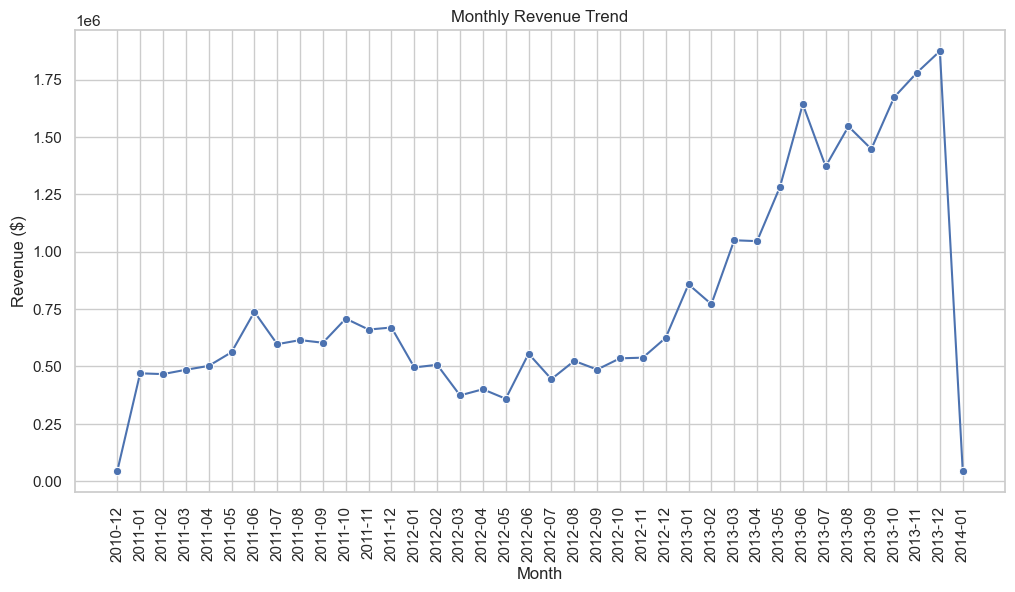

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# Convert Period to string for plotting
monthly_revenue['order_month_str'] = monthly_revenue['order_month'].astype(str)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
sns.lineplot(x='order_month_str', y='sales_amount', data=monthly_revenue, marker='o')
plt.xticks(rotation=90)
plt.title('Monthly Revenue Trend')
plt.ylabel('Revenue ($)')
plt.xlabel('Month')
plt.show()

## Product Performance KPIs

**Merge Sales with Products**

In [26]:
sales_products = fact_sales.merge(dim_products, on='product_key', how='left')

**Revenue per Product**

In [28]:
product_revenue = sales_products.groupby('product_name')['sales_amount'].sum().reset_index()
product_revenue = product_revenue.sort_values(by='sales_amount', ascending=False)
print(product_revenue.head(10))  # Top 10 products by revenue


               product_name  sales_amount
34   Mountain-200 Black- 46     1373454.0
33   Mountain-200 Black- 42     1363128.0
35  Mountain-200 Silver- 38     1339394.0
37  Mountain-200 Silver- 46     1301029.0
32   Mountain-200 Black- 38     1294854.0
36  Mountain-200 Silver- 42     1257368.0
58         Road-150 Red- 48     1205786.0
61         Road-150 Red- 62     1202208.0
59         Road-150 Red- 52     1080556.0
60         Road-150 Red- 56     1055510.0


**Profit and Margin**

In [29]:
sales_products['profit'] = sales_products['sales_amount'] - (sales_products['quantity'] * sales_products['cost'])
sales_products['profit_margin_pct'] = (sales_products['profit'] / sales_products['sales_amount']) * 100

product_profit = sales_products.groupby('product_name').agg(
    total_profit=('profit', 'sum'),
    avg_margin=('profit_margin_pct', 'mean')
).reset_index().sort_values(by='total_profit', ascending=False)

print(product_profit.head(10))


               product_name  total_profit  avg_margin
34   Mountain-200 Black- 46      597214.0   43.323285
33   Mountain-200 Black- 42      594400.0   43.451875
35  Mountain-200 Silver- 38      584858.0   43.515597
37  Mountain-200 Silver- 46      566749.0   43.406198
32   Mountain-200 Black- 38      566190.0   43.578524
36  Mountain-200 Silver- 42      548408.0   43.462757
58         Road-150 Red- 48      474159.0   39.323644
61         Road-150 Red- 62      472752.0   39.323644
59         Road-150 Red- 52      424914.0   39.323644
60         Road-150 Red- 56      415065.0   39.323644


**Repeat Purchase Rate**

In [30]:
repeat_purchase = sales_products.groupby('product_name').agg(
    unique_customers=('customer_key', 'nunique'),
    total_orders=('order_number', 'nunique')
).reset_index()

repeat_purchase['repeat_rate'] = repeat_purchase['total_orders'] / repeat_purchase['unique_customers']
repeat_purchase = repeat_purchase.sort_values(by='repeat_rate', ascending=False)

print(repeat_purchase.head(10))


              product_name  unique_customers  total_orders  repeat_rate
52     Patch Kit/8 Patches              2950          3191     1.081695
56          Road Tire Tube              2226          2376     1.067385
103      Touring Tire Tube              1411          1488     1.054571
8             HL Road Tire               820           858     1.046341
23      Mountain Tire Tube              2960          3095     1.045608
126  Water Bottle - 30 oz.              4073          4244     1.041984
21            ML Road Tire               891           926     1.039282
101  Sport-100 Helmet- Red              2147          2230     1.038659
14        LL Mountain Tire               830           862     1.038554
2    Bike Wash - Dissolver               875           908     1.037714
